Garmong, Sylvia
This interactive notebook fills the holes within the GEE generated DS of Normalized Friction Wind Speed
Requires IGMB, MODIS Radiances, Normalized Friction WS
Reference papers:

LeGrand et al. (2023) DOI: 10.5194/gmd-16-1009-2023

Chappell and Webb (2016) DOI: 10.1016/j.aeolia.2016.09.006

In [ ]:
import rasterio as rio # import packages
from rasterio.plot import show
from rasterio.merge import merge
import numpy as np
import matplotlib.pyplot as plt
import glob
import rioxarray
from scipy import interpolate

In [2]:
tiffFileNamesList = glob.glob('SWasia/*.tif') # GEE export produces multiple files need to merge

In [ ]:
tiffFileNamesList

In [3]:
friction_ws,outcrs = merge(tiffFileNamesList) # merge the files using rasterio

In [15]:
outcrs # affine transform for dataset

Affine(0.004491576420597608, 0.0, 16.72213901388489,
       0.0, -0.004491576420597608, 46.99985566513337)

In [4]:
friction_ws=friction_ws[2,:,:] #selecting the mean of the friction ws across the time period

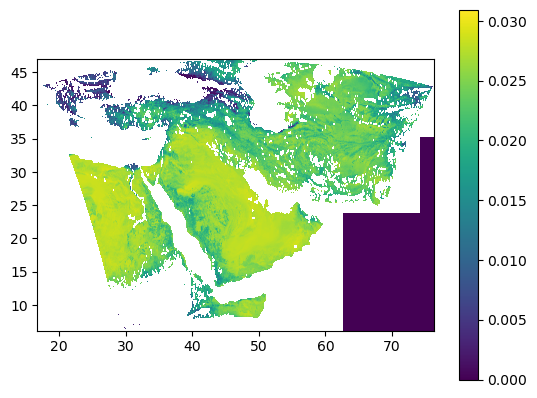

In [64]:
#quick visualization check
fig, ax1 = plt.subplots()
cat = show(friction_ws,transform=outcrs,ax=ax1,cmap='viridis')
im = cat.get_images()[0]
fig.colorbar(im, ax=ax1)

In [67]:
# this fixes the hole in the South East Corner of the Domain
init_fix1 = np.where(igmb!=0,friction_ws,np.nan)
init_fix2 = np.where(((igmb==17)&(init_fix1==0)),np.nan,init_fix1)

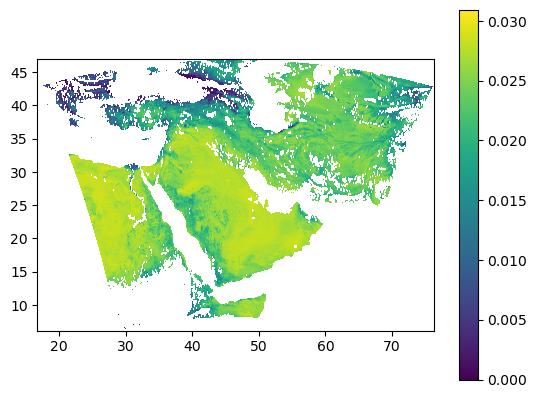

In [68]:
# quick vis of fix
fig, ax1 = plt.subplots()
cat = show(init_fix2,transform=outcrs,ax=ax1,cmap='viridis')
im = cat.get_images()[0]
fig.colorbar(im, ax=ax1)

Checking A known salt flat that seems to overwhelm MODIS QA in Oman as reference for what values should be used for salt flat fill

<Axes: >

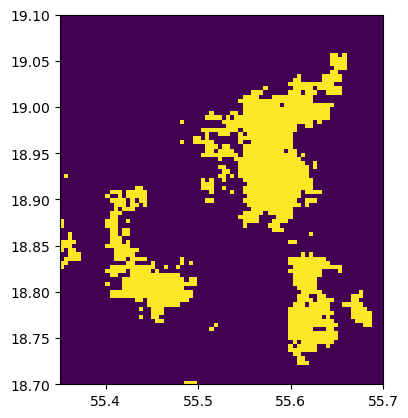

In [180]:
fig, ax1 = plt.subplots()
ax1.set_xlim(55.35,55.7)
ax1.set_ylim(18.7,19.1)
show(friction_ws>.0291,transform=landmaskcrs,ax=ax1)

Fill value based on a salt bed should be .0291 for high friction wind speed 

In [5]:
landmasklist = glob.glob('LanduseFull/*.tif') # grabbing land use files

In [6]:
landmask,landmaskcrs = merge(landmasklist) #merge

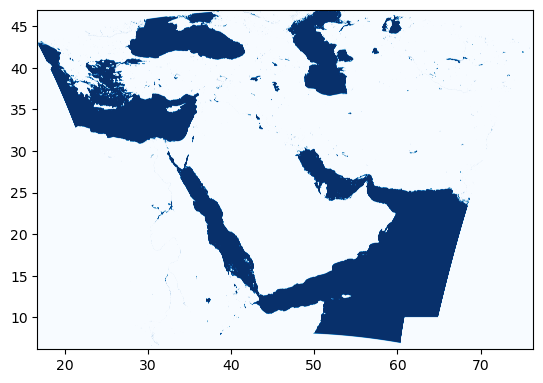

<Axes: >

In [29]:
show(np.where(landmask[12,:,:]==1,1,0),transform=landmaskcrs,with_bounds=True,cmap='Blues')

want landmask band 12 ==1 as a part of the mask

<Axes: >

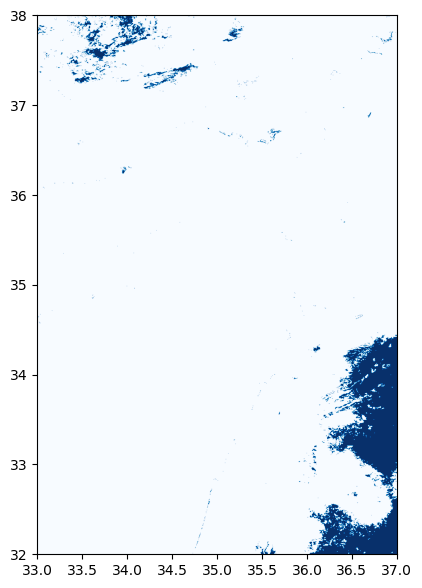

In [42]:
fig, ax = plt.subplots(figsize=(21,7))
ax.set_xlim(33,37)
ax.set_ylim(32,38)
show(np.where(landmask[0,:,:]==16,1,0),ax=ax,transform=landmaskcrs,with_bounds=True,cmap='Blues')
#show(np.where(landmask[0,:,:]==17,1,0),ax=ax,transform=landmaskcrs,with_bounds=True,cmap='Blues')

In [7]:
# dimension 0 is the igmb landuse
igmb = landmask[0,:,:]

landmask[0,:,:]==16 will help with forcing this on only landuses that are barren

In [9]:
# pulling in radiances here
radiance_list = glob.glob('MODISreflec/*.tif')
radiance,radiancecrs = merge(radiance_list)
red = radiance[0,:,:]
green = radiance[3,:,:]
blue = radiance[2,:,:]

In [58]:
print(red.shape,green.shape,blue.shape)

(9092, 13278) (9092, 13278) (11, 9092, 13278)


In [48]:
#quick check for radiance testing
test = np.where((green>2000),1,np.nan)

In [49]:
test.shape

(9092, 13278)

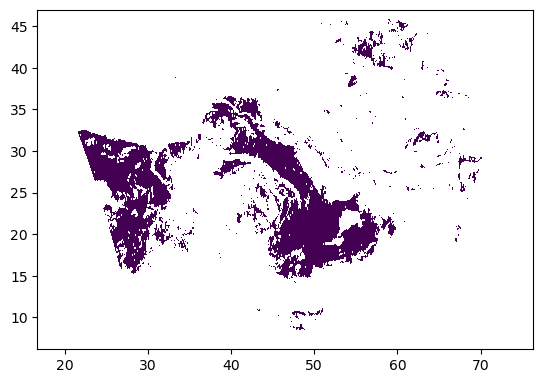

<Axes: >

In [50]:
show(test,transform=landmaskcrs)

Layer for Finding salt beds seems to be green < 2000 reflectance to fill in areas with low friction velocity -- will use max value of .38 for those areas
with additional 
will selectively apply with filter missing in original data, can't be water areas,and has to be barren.
will then apply a mean value to everywhere else that is land and missing data -- check on if snow is an issue

In [69]:
fixed_ws = np.where(np.isnan(init_fix2),-255,np.asarray(init_fix2)) # throwing all nans to -255 seems to be required for proper filling

<Axes: >

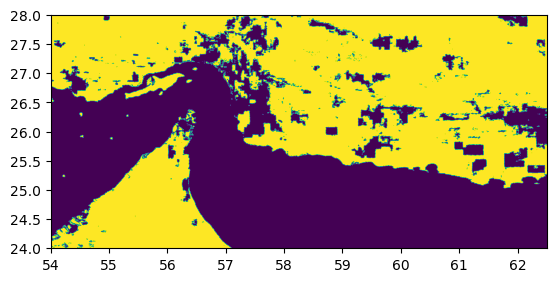

In [47]:
fig, ax1 = plt.subplots()
ax1.set_xlim(54,62.5)
ax1.set_ylim(24,28)
show(fixed_ws,transform=landmaskcrs,ax=ax1)

In [70]:
# main salt filling line is here
filtering = (radiance[3,:,:]>2000)&(igmb==16)&(fixed_ws==-255)&(np.isnan(radiance[3,:,:])==False)

In [71]:
filter_test = np.where(filtering,1,0)

<Axes: >

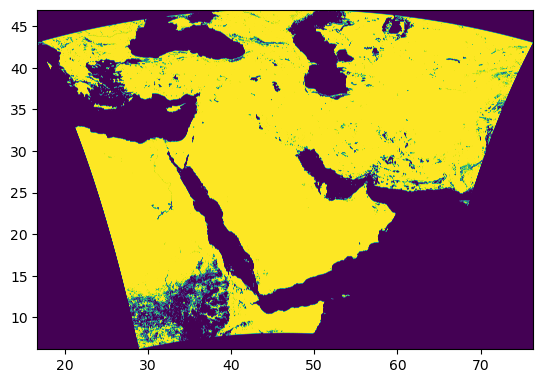

In [72]:
fig, ax1 = plt.subplots()

show(fixed_ws,transform=landmaskcrs,ax=ax1)

<Axes: >

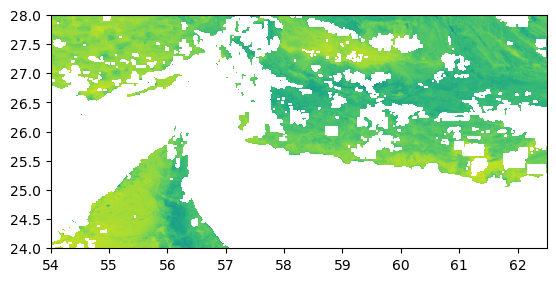

In [15]:
fig, ax1 = plt.subplots()
ax1.set_xlim(54,62.5)
ax1.set_ylim(24,28)
show(friction_ws,transform=landmaskcrs,ax=ax1)

<Axes: >

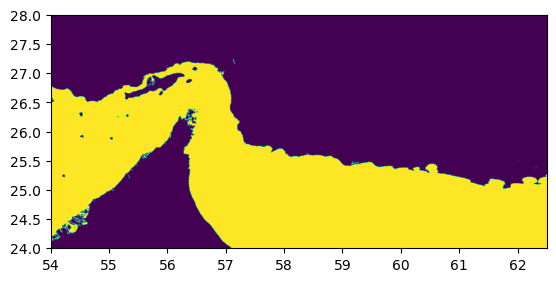

In [16]:
fig, ax1 = plt.subplots()
ax1.set_xlim(54,62.5)
ax1.set_ylim(24,28)
show(igmb==17,transform=landmaskcrs,ax=ax1)

In [73]:
filled_salt = np.where(filter_test==1,.0291,fixed_ws)
# filling salt here

<Axes: >

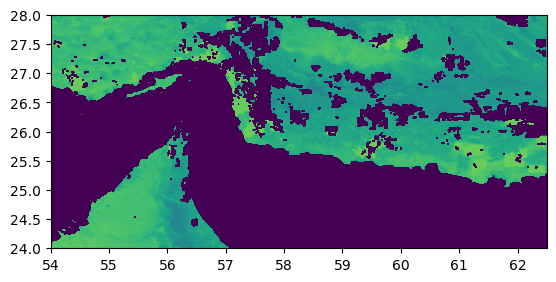

In [271]:
# quick check on how the fill looks
fig, ax1 = plt.subplots()
ax1.set_xlim(54,62.5)
ax1.set_ylim(24,28)
show(filled_salt,transform=landmaskcrs,ax=ax1,vmin=0.0,vmax=.038)

<Axes: >

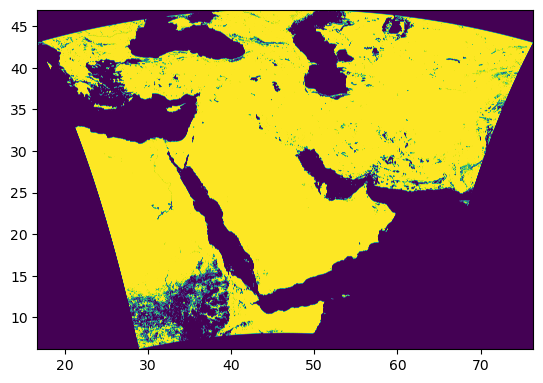

In [74]:
fig, ax1 = plt.subplots()

show(filled_salt==friction_ws,transform=landmaskcrs,ax=ax1)

In [287]:
(igmb==0).any()

True

In [112]:
water_fill = 

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [93]:
second_filter = (igmb!=17)&(filled_salt==-255)&(igmb!=15)

In [76]:
filled_done = np.where(second_filter,-255,filled_salt)

<Axes: >

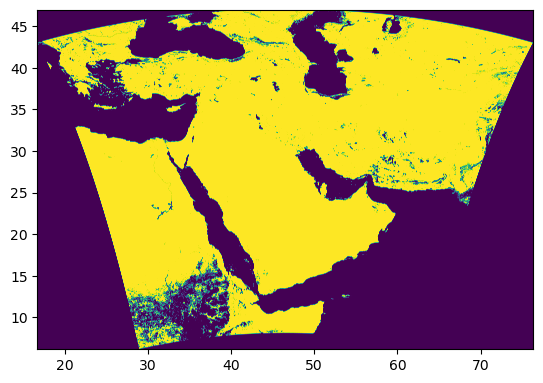

In [94]:
fig, ax1 = plt.subplots()

show(filled_done,transform=landmaskcrs,ax=ax1)

In [117]:
#finding water and throwing it back to 0 for for local mean filling -- will be ignored
water_fill = np.where(((igmb==17)|(igmb==0)),0,filled_salt)
water_fill_second = np.where(water_fill ==-255,np.nan,water_fill)

<Axes: >

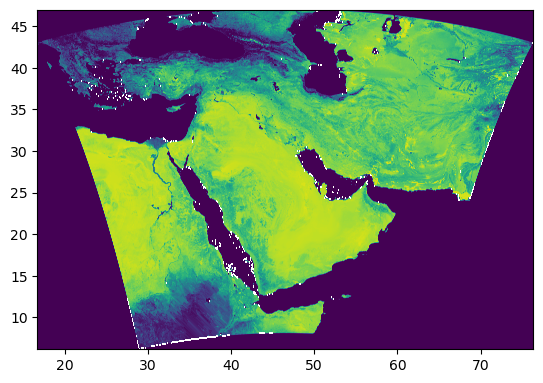

In [128]:
fig, ax1 = plt.subplots()

show(water_fill_second,transform=landmaskcrs,ax=ax1)

In [114]:
# local mean fill for a missing given i & j in the dataset
# checks for edges of the dataset & ignores water
def missing_finder(i,j):
    try:
        a = water_fill_second[i+1,j]
    except IndexError:
        a = np.nan
    try:
        b = water_fill_second[i,j+1]
    except IndexError:
        b = np.nan
    try:
        c = water_fill_second[i-1,j]
    except IndexError:
        c = np.nan
    try:
        d = water_fill_second[i,j-1]
    except IndexError:
        d = np.nan
    if ((igmb[i+1,j] == 17)|(igmb[i+1,j] == 0)):
        a = np.nan
    if ((igmb[i,j+1] == 17)|(igmb[i+1,j] == 0)):
        b = np.nan
    if ((igmb[i-1,j] == 17)|(igmb[i+1,j] == 0)):
        c = np.nan
    if ((igmb[i,j-1] == 17)|(igmb[i+1,j] == 0)):
        d = np.nan
    if (np.isnan(a) & np.isnan(b) & np.isnan(c) & np.isnan(d)):
        pass
    else:
        water_fill_second[i,j] = np.nanmean([a,b,c,d])
    

In [162]:
water_fill_second = np.where(water_fill ==-255,np.nan,water_fill)

In [163]:
# finds all locations of nans 
orig_nanlist = np.argwhere(np.isnan(water_fill_second))


In [167]:
# while loop that runs through all nans in the nanlist  and calls missing_finder on it - then removes the nan from nanlist
# operates on iterative fill to gradually fill in all locations from the edges
# also randomizes the lists to no specific location fills from a singular direction
# is done when there is no longer any location that can be filled
num = 0
while np.isnan(water_fill_second.any()) !=True:
    nanlist = np.argwhere(np.isnan(water_fill_second))
    np.random.shuffle(nanlist)
    for i in range(len(nanlist[:,0])):
        missing_finder(nanlist[i,0],nanlist[i,1])
    num = num + 1 
    nanlist_new = np.argwhere(np.isnan(water_fill_second))
    if len(nanlist_new) == len(nanlist):
        print("Done!")
        break
    print(num,"Lenth of nanlist ",len(nanlist))

[[7962 4002]
 [8588 4329]
 [7917 3640]
 ...
 [8067 3481]
 [8406 4132]
 [8431 5488]]
1 Lenth of nanlist  3662020
[[7980 3223]
 [8256 5115]
 [3393 9290]
 ...
 [7078 5788]
 [8203 4395]
 [8106 2940]]
2 Lenth of nanlist  2420288
[[ 3217 12066]
 [ 8339  2680]
 [ 8399  4409]
 ...
 [  846  5944]
 [ 3437 12058]
 [ 8469  3750]]
3 Lenth of nanlist  1758784
[[7510 4862]
 [8060 4719]
 [8276 4403]
 ...
 [8057 3789]
 [8231 4428]
 [7862 4466]]
4 Lenth of nanlist  1354560
[[8598 4347]
 [8783 4504]
 [7905 4422]
 ...
 [8327 4583]
 [8288 4373]
 [8124 3948]]
5 Lenth of nanlist  1082570
[[7647 4486]
 [8079 3729]
 [8348 4594]
 ...
 [8681 5047]
 [2298 7594]
 [8704 4185]]
6 Lenth of nanlist  888919
[[7866 4751]
 [2350 8043]
 [8006 4383]
 ...
 [7750 3725]
 [7728 3854]
 [8333 3751]]
7 Lenth of nanlist  743936
[[7529 4765]
 [7776 3703]
 [8393 5007]
 ...
 [8270 4353]
 [2336 8080]
 [8361 4473]]
8 Lenth of nanlist  632044
[[8407 4741]
 [8214 4485]
 [7805 4459]
 ...
 [8027 4429]
 [8717 4538]
 [8627 4138]]
9 Lenth of 

In [169]:
#quick smoothing of locations that were filled
for i in range(len(orig_nanlist[:,0])):
    missing_finder(orig_nanlist[i,0],orig_nanlist[i,1])

(5.0, 15.0)

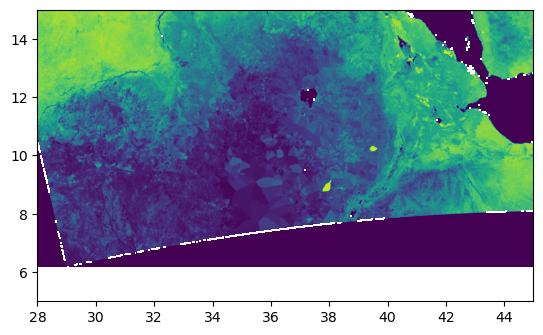

In [170]:
#visualization check
fig, ax1 = plt.subplots()

show(water_fill_second,transform=landmaskcrs,ax=ax1)
ax1.set_xlim(28,45)
ax1.set_ylim(5,15)

In [171]:
# throws water back to nan
nanforout = np.where(((igmb==17)|(igmb==0)),np.nan,water_fill_second)

<Axes: >

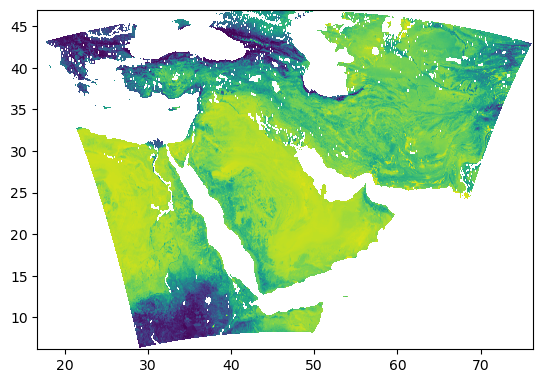

In [172]:
# check
fig, ax1 = plt.subplots()
show(nanforout,transform=landmaskcrs,ax=ax1)

In [300]:
#throw anywhere not filled to nan
filled_done = np.where(filled_done==-255,np.nan,filled_done) # replacing the -255 back to nans

Affine(0.004491576420597608, 0.0, 16.72213901388489,
       0.0, -0.004491576420597608, 46.99985566513337)

writing the fixed output to geotiff here

In [174]:
output_ds= rio.open('C:\\Users\\RDGRLRJG\\Documents\\SEasiaOutput\\TotalFixNormFricWS.tif','w',driver='GTiff',height=nanforout.shape[0],width=nanforout.shape[1],count=1,dtype=nanforout.dtype,crs='EPSG:4326',transform=landmaskcrs)
output_ds.write(nanforout, 1)
output_ds.close()